In [1]:
from fastai.vision.all import *
import warnings
from PIL import Image

path = Path('inputs')/'processed'
warnings.filterwarnings("ignore")

In [2]:
ims = get_image_files(path)
total_images = len(ims)
print(f"Total images: {total_images}")

Total images: 12643


In [3]:
import torch; print(torch.cuda.get_device_name(0))

# Flush CUDA memory
torch.cuda.empty_cache()

import gc
gc.collect()

NVIDIA GeForce RTX 4070 Ti


66

In [5]:
import os

def _my_grandparent_idxs(items, name):
    def _inner(items, name): 
        return mask2idxs(name in str(Path(o)) for o in items)
    return [i for n in L(name) for i in _inner(items,n)]

def MyGrandparentSplitter(train_name='train', valid_name='valid'):
    "Split `items` from the grand parent folder names (`train_name` and `valid_name`)."
    def _inner(o):
        return _my_grandparent_idxs(o, train_name),_my_grandparent_idxs(o, valid_name)
    return _inner
    


In [6]:
fnames = [
    path/'train/cat/a/9932.png', path/'valid/cat/a/7189.png',
    path/'train/cat/b/9932.png', path/'valid/cat/b/7189.png',
    path/'train/not-a-pet/9932.png', path/'valid/not-a-pet/7189.png',
]
splitter = MyGrandparentSplitter()

In [7]:
def _test_splitter(f, items=None):
    "A basic set of condition a splitter must pass"
    items = ifnone(items, range_of(30))
    trn,val = f(items)
    assert 0<len(trn)<len(items)
    assert all(o not in val for o in trn)
    test_eq(len(trn), len(items)-len(val))
    # test random seed consistency
    test_eq(f(items)[0], trn)
    return trn, val

In [8]:
_test_splitter(splitter, items=fnames)
test_eq(splitter(fnames),[[0,2,4],[1,3,5]])

In [9]:
def parent_label_list(o):
    """
    Returns the parent label of the image as a list
    This is required for a Miltilabel classification problem

    Args:
        o (_type_): _description_

    Returns:
        _type_: _description_
    """
    label = parent_label(o)
    grand_parent_label = o.parent.parent.name
    if label == 'not-a-pet':
        return [label]
    
    return [grand_parent_label[:-1], label]

dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_items=get_image_files,
    splitter=MyGrandparentSplitter(train_name='train', valid_name='valid'),
    get_y=parent_label_list,
    # not required as i am pre-processing images
    item_tfms=Resize(460), 
    batch_tfms=aug_transforms(size=224, min_scale=0.75),
)

dblock.summary(path)


Setting-up type transforms pipelines
Found 12643 items
2 datasets of sizes 10097,1286
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label_list -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}

Building one sample
  Pipeline: PILBase.create
    starting from
      inputs/processed/train/cats/Abyssinian/000c79b4-d828-4e54-a0d0-341fbc898aef.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=736x1108
  Pipeline: parent_label_list -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}
    starting from
      inputs/processed/train/cats/Abyssinian/000c79b4-d828-4e54-a0d0-341fbc898aef.jpg
    applying parent_label_list gives
      [cat, Abyssinian]
    applying MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorMultiCategory([45,  0])
    applying OneHotEncode -- {'c': None} gives
      TensorMultiCategory of size 47

Final sample: 

In [10]:

dls = dblock.dataloaders(path, bs=32)
print(dls.vocab)


['Abyssinian', 'American Bobtail', 'American Curl', 'American Shorthair', 'American Wirehair', 'Balinese', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Burmese', 'Chartreux', 'Cheetoh', 'Cornish Rex', 'Devon Rex', 'Egyptian Mau', 'Exotic Shorthair', 'Havana Brown', 'Japanese Bobtail', 'Khao Manee', 'LaPerm', 'Lykoi', 'Maine Coon', 'Manx', 'Munchkin', 'Norwegian Forest Cat', 'Ocicat', 'Oriental Shorthair', 'Persian', 'Peterbald', 'Ragdoll', 'Russian Blue', 'Savannah', 'Scottish Fold', 'Selkirk Rex', 'Siamese', 'Siberian', 'Singapura', 'Snowshoe', 'Somali', 'Sphynx', 'Tonkinese', 'Toyger', 'Turkish Angora', 'Turkish Van', 'cat', 'not-a-pet']


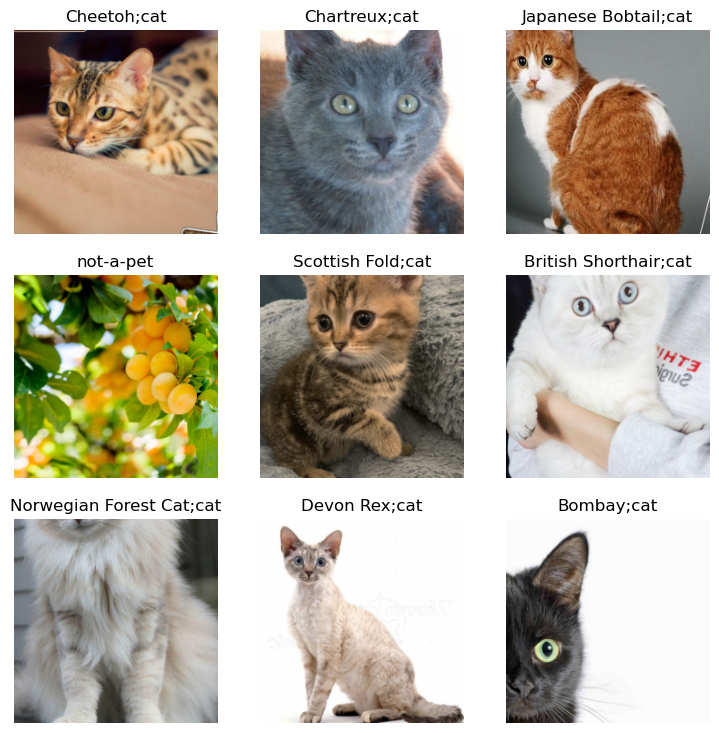

In [11]:
# dls.summary(path)
dls.show_batch(max_n=9)


Minimum/10: 6.31e-02, steepest point: 3.98e-02
Slide: 2.29e-02, Valley: 2.09e-03


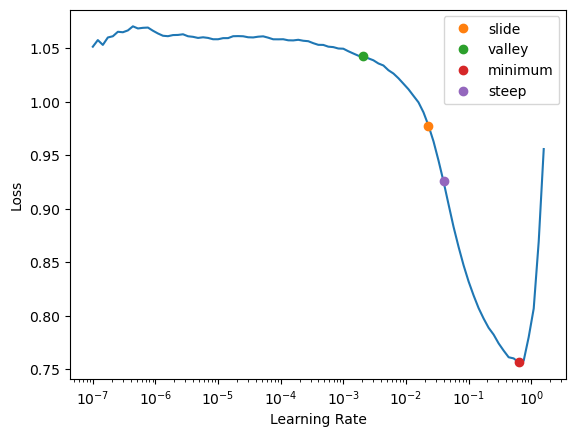

In [12]:
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
from fastai.vision.all import *
import timm

# Define the CustomHead class with shape inspection
# class CustomHead(nn.Module):
#     def __init__(self, nf, n_out):
#         super().__init__()
#         self.pool = nn.AdaptiveAvgPool2d(1)
#         self.flatten = nn.Flatten()
#         self.linear = nn.Linear(nf, n_out)

#     def forward(self, x):
#         if x.dim() == 2:  # No spatial dimensions (1D features per image)
#             # print("Input is 2D, skipping pooling.")
#             x = self.flatten(x)
#         elif x.dim() == 4:  # Regular case: [batch_size, channels, height, width]
#             x = self.pool(x)
#             # print(f"Shape after pooling: {x.shape}")
#             x = self.flatten(x)
#         else:
#             raise ValueError(f"Unexpected input dimension: {x.dim()} dimensions.")
#         # print(f"Shape after flattening: {x.shape}")
#         x = self.linear(x)
#         return x

# Create the model
# model_name = 'resnet18'  # Replace with your model name
model_name = 'convnext_tiny'  # Replace with your model name
# model_name = 'convnext_large'  # Replace with your model name
# the_model = timm.create_model(
#     model_name,
#     pretrained=True,
#     num_classes=0)  # num_classes=0 to exclude the final layer

# Move the model to the GPU if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# the_model.to(device)

# Inspect the output shape
# x, _ = dls.one_batch()
# x = x.to(device)  # Move the input tensor to the same device as the model
# with torch.no_grad():
#     output = the_model(x)
# print(f"Output shape: {output.shape}")

# Extract the number of features
# nf = output.shape[1] if output.dim() == 4 else output.shape[-1]  # Handle cases where output is 1D or 4D

# Combine the backbone and custom head
# model = nn.Sequential(
#     the_model,
#     CustomHead(nf=nf, n_out=len(dls.vocab))
# )

# Create the learner
# learn = Learner(
#     dls,
#     model,
#     loss_func=BCEWithLogitsLoss(),
#     metrics=accuracy_multi,
# ).to_bf16()

# Create the learner
learn = vision_learner(
    dls,
    # resnet50,
    resnet101,
    # resnet152,
    loss_func=BCEWithLogitsLoss(),
    metrics=accuracy_multi
).to_bf16()

lr_slide, lr_valley, lr_min, lr_steep = learn \
    .lr_find(suggest_funcs=(slide, valley, minimum, steep))
    
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")
print(f"Slide: {lr_slide:.2e}, Valley: {lr_valley:.2e}")

In [15]:
learn.fine_tune(8, base_lr=3.98e-02, freeze_epochs=3)
learn.export('resnet101.pkl')

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.053953,75.303596,0.976473,00:55
1,0.053425,205.287308,0.973710,00:53
2,0.053350,75.953133,0.977301,01:06
3,0.052022,416.700470,0.972949,01:34
4,0.051821,305.091187,0.972983,01:35
5,0.051438,303.487427,0.972503,02:55
6,0.052014,261.188812,0.973363,00:18
7,0.052588,353.366821,0.970004,01:37


In [13]:
print(dls.bs)

32


In [16]:
learn.fit??

Signature:
learn.fit(
    n_epoch,
    lr=None,
    wd=None,
    cbs=None,
    reset_opt=False,
    start_epoch=0,
)
Docstring: Fit `self.model` for `n_epoch` using `cbs`. Optionally `reset_opt`.
Source:   
    def fit(self, n_epoch, lr=None, wd=None, cbs=None, reset_opt=False, start_epoch=0):
        if start_epoch != 0:
            cbs = L(cbs) + SkipToEpoch(start_epoch)
        with self.added_cbs(cbs):
            if reset_opt or not self.opt: self.create_opt()
            if wd is None: wd = self.wd
            if wd is not None: self.opt.set_hypers(wd=wd)
            self.opt.set_hypers(lr=self.lr if lr is None else lr)
            self.n_epoch = n_epoch
            self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
File:      ~/miniconda3/envs/work/lib/python3.11/site-packages/fastai/learner.py
Type:      method

In [19]:
doc(learn.fit_one_cycle)


In [15]:
# much better accuracy going from bs=16 to bs=32, immediate difference
# makes sense since the model is seeing more images per batch
learn.fit_one_cycle(3, 1e-1)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.134549,0.312561,0.974571,00:41
1,0.104712,22.976391,0.972999,00:42
2,0.085120,12.290123,0.976109,00:41


In [16]:
# the shape represents the no in batch, no of classes
# the values represent the probability of the image belonging to the class
x,y = dls.train.one_batch()
activs = learn.model(x)

print(activs.shape)
print(activs[0])
print(y)
# from this you can see the activations have not been scaled yet
# oh and these are logits, not probabilities, raw output of activations

torch.Size([32, 47])
TensorImage([-2.7311, -3.3386, -4.0731, -4.2626, -4.3103, -6.3628, -3.2735,
             -7.5925, -7.6404, -4.8196, -5.0679, -6.6432, -2.9495, -3.7100,
             -4.4081, -4.6991, -5.0123, -5.9401, -5.2071, -6.2315, -4.2790,
             -4.4319, -4.1442, -4.2942, -4.7450, -4.4135, -2.3349, -4.0136,
             -5.5426, -3.2864, -7.2494, -7.3617, -4.0337, -5.2239, -5.0962,
             -6.3633, -4.4860, -3.7853, -6.0537, -2.2707, -3.4129, -5.9477,
             -2.6802, -5.7955, -6.6676,  2.7205, -2.7217], device='cuda:0',
            grad_fn=<AliasBackward0>)
TensorMultiCategory([[0., 0., 0.,  ..., 0., 1., 0.],
                     [0., 0., 0.,  ..., 0., 1., 0.],
                     [0., 0., 0.,  ..., 0., 1., 0.],
                     ...,
                     [0., 0., 0.,  ..., 0., 0., 1.],
                     [0., 0., 0.,  ..., 0., 1., 0.],
                     [0., 0., 0.,  ..., 0., 1., 0.]], device='cuda:0')


In [17]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, torch.tensor(y))
loss

TensorImage(0.0830, device='cuda:0', grad_fn=<AliasBackward0>)

In [18]:
learn.unfreeze()

SuggestedLRs(valley=9.120108734350652e-05)

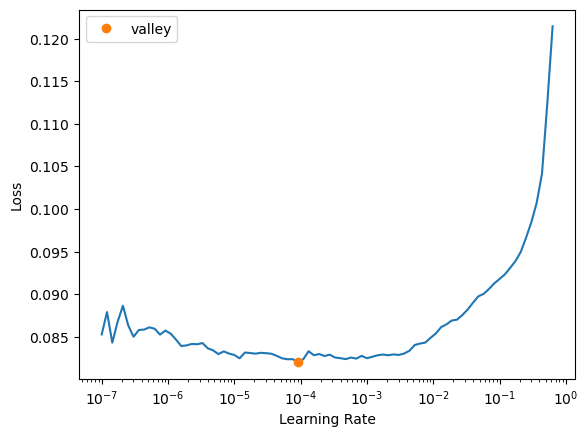

In [19]:
learn.lr_find()

In [20]:
learn.fit_one_cycle(3, 9.12e-5)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.083506,47.564991,0.971758,00:43
1,0.079712,14.642698,0.978177,02:04
2,0.078566,12.156057,0.978062,-1:59:25


SuggestedLRs(valley=0.002511886414140463)

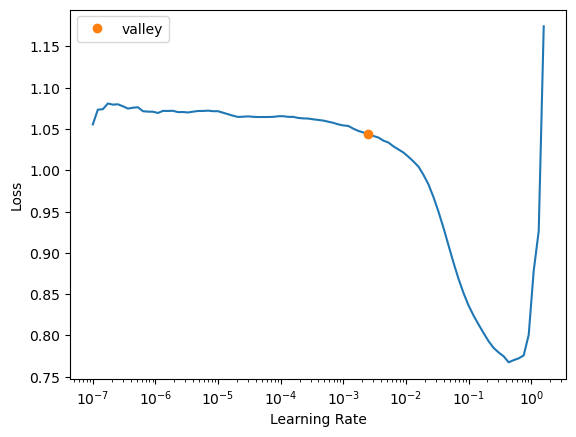

In [20]:

# learn = vision_learner(dls, model, metrics=error_rate)
learn = vision_learner(
    dls,
    resnet50,
    loss_func=BCEWithLogitsLoss(),
    metrics=accuracy_multi,
).to_bf16()
learn.lr_find()


In [ ]:
learn.fit_one_cycle(3, 0.002511886414140463)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

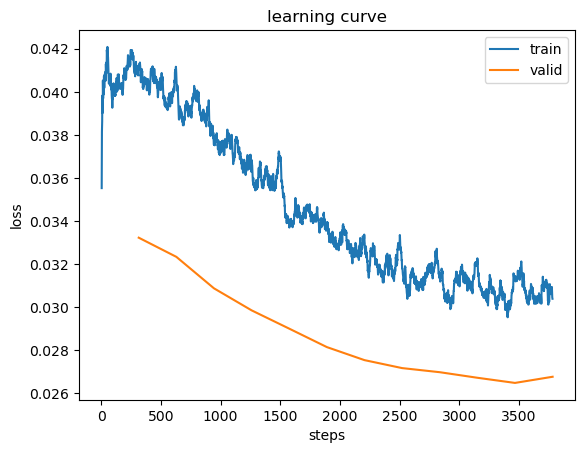

In [22]:
learn.recorder.plot_loss()

In [17]:
learn.fine_tune??

Signature:
learn.fine_tune(
    epochs,
    base_lr=0.002,
    freeze_epochs=1,
    lr_mult=100,
    pct_start=0.3,
    div=5.0,
    *,
    lr_max=None,
    div_final=100000.0,
    wd=None,
    moms=None,
    cbs=None,
    reset_opt=False,
    start_epoch=0,
)
Source:   
@patch
@delegates(Learner.fit_one_cycle)
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `Learner.freeze` for `freeze_epochs`, then with `Learner.unfreeze` for `epochs`, using discriminative LR."
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)
File:      ~/miniconda3/envs/work/lib/python3.11/site-packages/fastai/callback/schedule.py
Type:      method

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.207254,0.073381,0.981652,00:41
1,0.063686,0.045231,0.984365,00:41
2,0.054444,0.041092,0.985573,00:40
3,0.049377,0.037117,0.986764,02:00
4,0.044829,0.032677,0.988501,-1:59:21


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.034516,0.027195,0.990404,00:42
1,0.032708,0.026962,0.990470,00:42
2,0.034426,0.030305,0.989345,00:42
3,0.032056,0.028711,0.990156,00:42
4,0.029661,0.026946,0.991198,00:42
5,0.025915,0.025342,0.991711,00:42
6,0.021854,0.024986,0.991909,00:43
7,0.017311,0.024992,0.992538,00:43
8,0.013728,0.024726,0.993034,00:42
9,0.009761,0.025457,0.992919,00:43


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

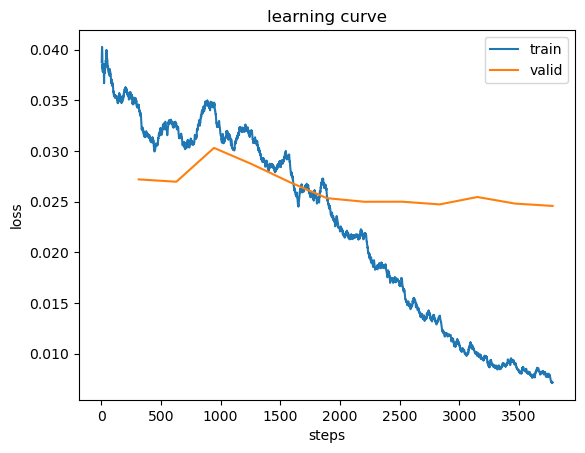

In [23]:
learn = vision_learner(
    dls,
    resnet50,
    loss_func=BCEWithLogitsLoss(),
    metrics=accuracy_multi,
).to_bf16()
learn.fine_tune(12, base_lr=1e-2, freeze_epochs=5)
learn.recorder.plot_loss()

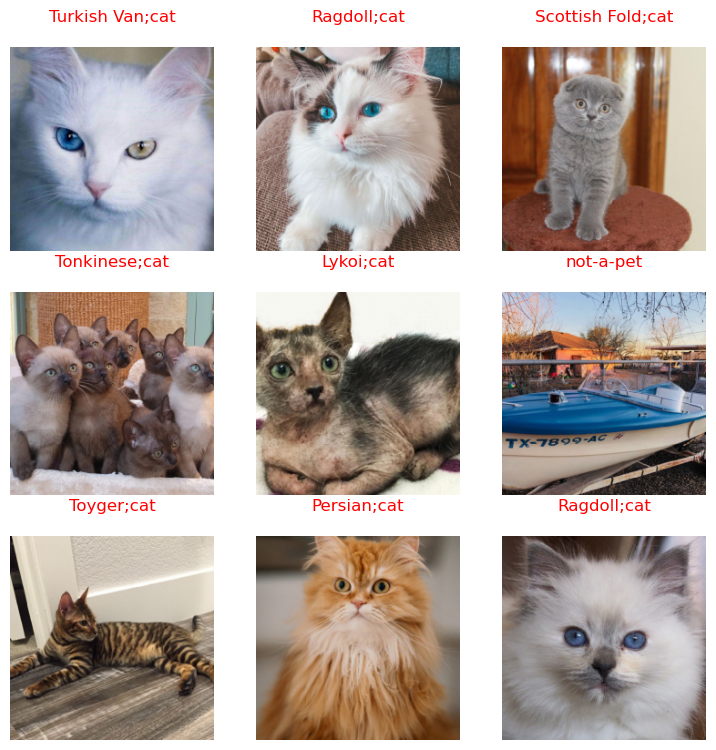

In [24]:
learn.show_results()

In [25]:
learn.export('resnet50.pkl')

In [29]:
learn.validate??

Signature: learn.validate(ds_idx=1, dl=None, cbs=None)
Docstring: Validate on `dl` with potential new `cbs`.
Source:   
    def validate(self, ds_idx=1, dl=None, cbs=None):
        if dl is None: dl = self.dls[ds_idx]
        with self.validation_context(cbs=cbs): self._do_epoch_validate(ds_idx, dl)
        return getattr(self, 'final_record', None)
File:      ~/miniconda3/envs/work/lib/python3.11/site-packages/fastai/learner.py
Type:      method

In [34]:
learn.metrics = partial(accuracy_multi, thresh=0.4)
learn.validate()

(#2) [0.024574777111411095,0.9932167530059814]

In [31]:
preds,targs = learn.get_preds()
print(preds)
pred_labels = preds.argmax(dim=1)
print(pred_labels)

tensor([[  7.7500, -15.4375, -20.1250,  ..., -20.6250,  17.6250, -17.3750],
        [ -1.7031,  -7.8750, -10.8125,  ..., -12.5000,  12.4375, -12.4375],
        [  8.4375, -18.1250, -23.5000,  ..., -24.5000,  21.8750, -21.6250],
        ...,
        [-15.6250, -14.8750, -14.0000,  ..., -12.2500, -13.7500,  13.7500],
        [-22.3750, -24.1250, -17.1250,  ..., -20.7500, -18.2500,  18.2500],
        [-15.6875, -16.6250, -16.2500,  ..., -17.1250, -18.0000,  18.0000]])
tensor([[1., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


In [38]:
preds, targs = learn.get_preds()
pred_labels = preds.argmax(dim=1)
print(pred_labels)

# use vocab to get the class names for each prediction
labels = [learn.dls.vocab[pred] for pred in pred_labels]
print (labels)
print(dls.vocab[pred_labels[0]])

ERROR:tornado.general:SEND Error: Host unreachable


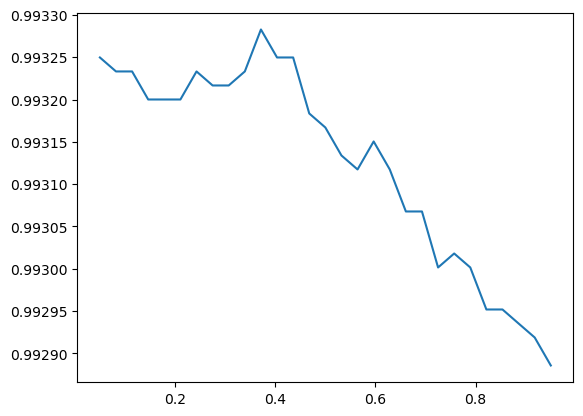

In [33]:
# used to determine the threshold for the accuracy

xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

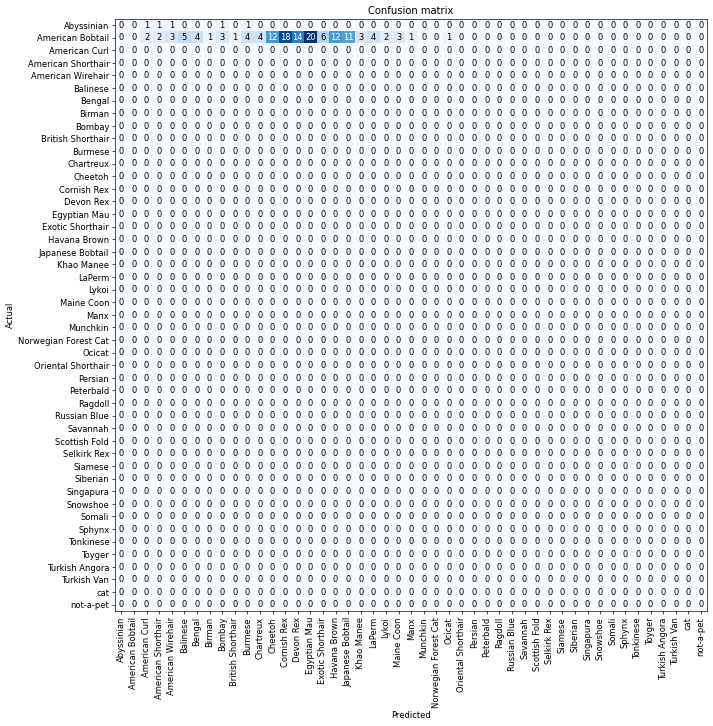

In [26]:
#width 600
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [27]:
interp.most_confused(min_val=5)

[('American Bobtail', 'Egyptian Mau', 20),
 ('American Bobtail', 'Cornish Rex', 18),
 ('American Bobtail', 'Devon Rex', 14),
 ('American Bobtail', 'Cheetoh', 12),
 ('American Bobtail', 'Havana Brown', 12),
 ('American Bobtail', 'Japanese Bobtail', 11),
 ('American Bobtail', 'Exotic Shorthair', 6),
 ('American Bobtail', 'Balinese', 5)]

In [23]:
from fastbook import *
from fastai.vision.widgets import *

cleaner = ImageClassifierCleaner(learn)
cleaner

In [23]:
from fastai.vision.all import PILImage
from PIL import Image
import numpy as np

# Debug: Check if learn object is loaded
try:
    print(f"Model loaded: {learn}")
except NameError:
    print("Error: 'learn' object is not defined or not loaded.")

# Debug: Check if dls object is loaded
try:
    print(f"DataLoaders loaded: {dls}")
    print(f"Vocabulary: {dls.vocab}")
except NameError:
    print("Error: 'dls' object is not defined or not loaded.")
except AttributeError:
    print("Error: 'dls' object does not have the expected attributes.")


def perform_prediction(img_path, show_image=True):
    try:
        img = PILImage.create(img_path)
        if show_image: img.show()
        # print("Image loaded successfully.")
        # print(f"Image shape: {img.shape}")
        # print(f"Image type: {type(img)}")
    except Exception as e:
        print(f"Error loading image: {e}")

    # Predict on a new image
    try:
        pred, pred_idx, probs = learn.predict(img)
        probs = sigmoid(probs)
        # print(f"Predicted labels: {pred}")
        # print(f"Prediction indices: {pred_idx}")
        # print(f"Probabilities: {probs}")
    except Exception as e:
        print(f"Error in prediction: {e}")

    # Predict on a new image
    try:
        not_a_pet_idx = list(dls.vocab).index('not-a-pet')
        # print(f"Index of 'not-a-pet' in vocabulary: {not_a_pet_idx}")
    except Exception as e:
        print(f"Error finding 'not-a-pet' in vocabulary: {e}")

    # Set a threshold
    threshold = 0.2
    is_not_pet = probs[not_a_pet_idx] > threshold 

    if is_not_pet:
        return "This is not a pet image."
    else:
        # Get the top 5 predictions
        top5_idx = probs.argsort(descending=True)[:5]
        top5_probs = probs[top5_idx]
        top5_breeds = [dls.vocab[i] for i in top5_idx]

        # Format the output
        result = "Top 5 predictions:\n"
        for breed, prob in zip(top5_breeds, top5_probs):
            result += f"{breed}: {prob:.4f}\n"
        
        return result

Model loaded: <fastai.learner.Learner object at 0x7fad059ab850>
DataLoaders loaded: <fastai.data.core.DataLoaders object at 0x7fac1d145f90>
Vocabulary: ['Abyssinian', 'American Bobtail', 'American Curl', 'American Shorthair', 'American Wirehair', 'Balinese', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Burmese', 'Chartreux', 'Cheetoh', 'Cornish Rex', 'Devon Rex', 'Egyptian Mau', 'Exotic Shorthair', 'Havana Brown', 'Japanese Bobtail', 'Khao Manee', 'LaPerm', 'Lykoi', 'Maine Coon', 'Manx', 'Munchkin', 'Norwegian Forest Cat', 'Ocicat', 'Oriental Shorthair', 'Persian', 'Peterbald', 'Ragdoll', 'Russian Blue', 'Savannah', 'Scottish Fold', 'Selkirk Rex', 'Siamese', 'Siberian', 'Singapura', 'Snowshoe', 'Somali', 'Sphynx', 'Tonkinese', 'Toyger', 'Turkish Angora', 'Turkish Van', 'not-a-pet']


In [24]:
img_path = Path('test/Abyssinian/05a5a708-5a74-40b3-826c-2cc47b6a50c0.jpg')
print(perform_prediction(img_path))



Error loading image: [Errno 2] No such file or directory: '/mnt/s/study/fastai_cat_clasifier/test/Abyssinian/05a5a708-5a74-40b3-826c-2cc47b6a50c0.jpg'
Error in prediction: cannot access local variable 'img' where it is not associated with a value


UnboundLocalError: cannot access local variable 'probs' where it is not associated with a value